In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import itertools as it
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from evaluation import get_util
# from model_utils import *

In [2]:
# Need the `dot` command from graphviz to visualize tree with `env.render()`
# -> install graphviz by running BOTH commands below:
# conda install graphviz
# pip install graphviz

# make sure `dot` is in the path
import os
os.environ['PATH'] +=':/home/fredcallaway/miniconda3/envs/mcrl/bin/'

# Mouselab-MDP Environment

We construct a Mouselab-MDP with a symmetric tree structure by specifying a branching structure
and a function `reward(depth) -> Distribution` that specifies the reward distribution for
the nodes at each depth. The ground truth for each environment is determined when the `MouselabEnv`
object is instantiated. We can keep the ground truth constant by specifying a `seed` value. Each
env will have a different ground truth, but if we call `envs = make_envs(n=10, seed=1)` multiple times,
`env[4]` will always have the same ground truth.

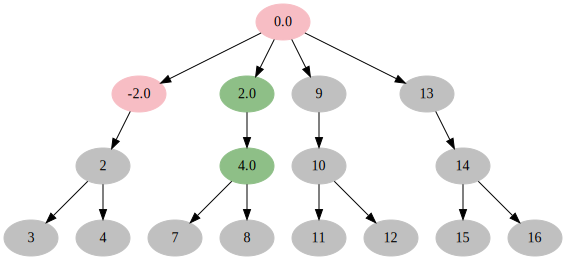

In [3]:
from mouselab import MouselabEnv
from distributions import Categorical, Normal

def make_envs(cost=1, n=100, seed=None):
    if seed is not None:
        np.random.seed(seed)
    def reward(depth):
        if depth > 0:
            return Normal(0, 5 * depth).to_discrete(6)
        return 0.
    branching=[4,1,2]
    return [MouselabEnv.new_symmetric(branching, reward)
            for _ in range(n)]

env = make_envs(n=1, seed=17)[0]
env.reset()
for a in [1, 5, 6,]:
    env.step(a)
env.render()

Upon termination, the agent receives the expected return of taking an optimal path given the
current belief state _and_ the ground truth. Unbeknownst to you (or the agent), 
nodes 7 and 8 both have value `6.0`. Thus, the reward for terminating is `12.0`.

In [4]:
# env._term_reward() gives the true termination reward
print('true term reward:     ', env._term_reward())
# env.term_reward() gives the distribution of termination rewards given the current belief.
print('expected term reward: ', env.term_reward().expectation())
# In general, a preceding underscore indicates that an agent should 
# not have access to that method.

true term reward:      12.0
expected term reward:  6.0


# Linear softmax policy

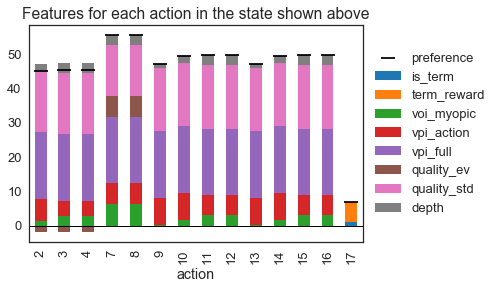

In [5]:
from mouselab_policy import MouselabPolicy

agent = Agent()
theta = np.ones(8)
weights = {
    'is_term': 1,
    'term_reward': 1,
    'voi_myopic': 1,
    'vpi_action': 1,
    'vpi_full': 1,
    'quality_ev': 1,
    'quality_std': 1,
    'depth': 1,
}
pol = MouselabPolicy(weights, temp=1)
agent.register(env)
agent.register(pol)

actions = list(env.actions(env._state))
phi = [pol.phi(env._state, action)[:-1]  # leave out dummy coefficient
       for action in actions]

phi = pd.DataFrame(phi, index=actions, columns=weights.keys())
phi.plot.bar(stacked=True, legend=False)
plt.scatter(range(len(phi)), phi.sum(1), 
            c='k', marker='_', s=200, zorder=10, label='preference')
plt.axhline(0, c='k', lw=1)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('action')
plt.title('Features for each action in the state shown above')

# Optimized LC policy

In [36]:
train_envs = make_envs(1.25, n=10, seed=10)

def lc_policy(x, normalize_voi=True):
    x = np.array(x)
    assert len(x) == 4, x
    voi = x[1:]
    if normalize_voi and voi.sum():
        voi /= voi.sum()
    # Note: an `is_term` feature is functionally equivalent to a `cost` feature
    # when all clicks have the same cost.
    weights = dict(zip(['is_term', 'voi_myopic', 'vpi_action', 'vpi_full'], x))
    return MouselabPolicy(weights)

def loss(x):
    with Timer() as t:
        util = get_util(lc_policy(x), train_envs)
        xs =  np.array2string(np.array(x), 
                              formatter={'float_kind': lambda x: f'{x: 6.2f}'})
        print(f'{xs} -> {util:6.3f}  ({t.elapsed:2.1f} seconds)')
    return - util

bounds = [
    (-30., 30.), # is_term
    (0., 1.),    # voi_myopic
    (0., 1.),    # vpi_action
    (0., 1.),    # vpi_full
]

from skopt import gp_minimize
result = gp_minimize(loss, bounds, n_calls=10, random_state=0)
opt_pol = lc_policy(result.x)

[  2.93   0.72   0.60   0.54] -> 15.800  (0.2 seconds)
[ -4.58   0.65   0.44   0.89] -> 19.200  (0.3 seconds)
[ 27.82   0.38   0.79   0.53] -> -2.350  (0.1 seconds)
[  4.08   0.93   0.07   0.09] -> 15.600  (0.2 seconds)
[-28.79   0.83   0.78   0.87] -> 21.600  (0.4 seconds)
[ 28.72   0.80   0.46   0.78] -> -2.350  (0.1 seconds)
[-22.90   0.64   0.14   0.94] -> 22.000  (0.4 seconds)
[  1.31   0.41   0.26   0.77] -> 19.200  (0.3 seconds)
[ -2.63   0.57   0.02   0.62] -> 20.800  (0.3 seconds)
[  6.73   0.62   0.94   0.68] ->  1.200  (0.1 seconds)
